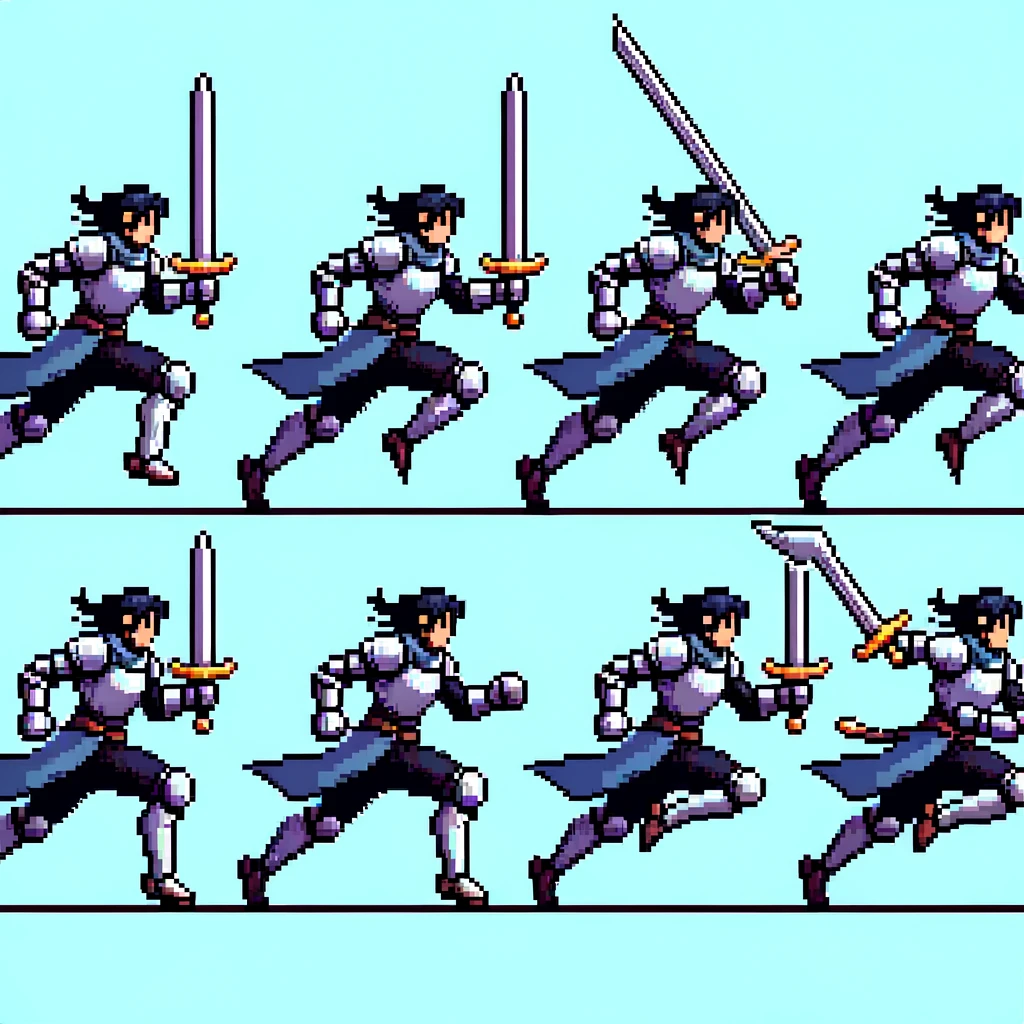

In [16]:
from PIL import Image
img=Image.open("D:/img/foo/ss2.png")
img

In [53]:
from collections import Counter

from PIL import Image

import numpy as np

import matplotlib.pyplot as plt


def compute_fft_cross_correlation(img1, img2):

    fft1 = np.fft.fft2(img1)

    fft2 = np.fft.fft2(np.rot90(img2, 2), s=img1.shape)

    result = np.fft.ifft2(fft1 * fft2).real

    return result



def compute_offsets(reference, images, window_size):

    reference_gray = np.array(reference.convert('L'))

    offsets = []

    for img in images:

        img_gray = np.array(img.convert('L'))

        correlation = compute_fft_cross_correlation(reference_gray, img_gray)

        # Roll the correlation by half the width and height
        height, width = correlation.shape
        correlation = np.roll(correlation, height // 2, axis=0)
        correlation = np.roll(correlation, width // 2, axis=1)

        #plot the correlation
        fig, axs = plt.subplots(1, 3, figsize=(10, 5))
        axs[0].imshow(reference_gray, cmap='gray')
        axs[0].set_title('Reference')
        axs[1].imshow(img_gray, cmap='gray')
        axs[1].set_title('Image')
        axs[2].imshow(correlation, cmap='hot', interpolation='nearest', extent=[-window_size, window_size, -window_size, window_size])
        axs[2].set_title('Correlation')
        plt.show()        

        # Find the peak in the central region of the correlation
        center_x, center_y = height // 2, width // 2
        start_x, start_y = center_x - window_size // 2, center_y - window_size // 2
        end_x, end_y = start_x + window_size, start_y + window_size
        peak_x, peak_y = np.unravel_index(np.argmax(correlation[start_x:end_x, start_y:end_y]), (window_size, window_size))

        # Compute the offset in the range [-window_size, window_size]
        peak_x += start_x - center_x + 1
        peak_y += start_y - center_y + 1

        #signs are wrong
        #peak_x = -peak_x
        #peak_y = -peak_y

        print(peak_x, peak_y)

        # Compute the offset in the range [-window_size, window_size]
        if peak_x > correlation.shape[0] // 2:
            peak_x -= correlation.shape[0]
        if peak_y > correlation.shape[1] // 2:
            peak_y -= correlation.shape[1]

        if peak_x >= 0:
            peak_x = min(peak_x, window_size)
        else:
            peak_x = max(peak_x, -window_size)

        if peak_y >= 0:
            peak_y = min(peak_y, window_size)
        else:
            peak_y = max(peak_y, -window_size)

        offsets.append((peak_x, peak_y))

    return offsets


def find_most_common_color(image):

    pixels = list(image.getdata())

    color_counter = Counter(pixels)

    return color_counter.most_common(1)[0][0]



def slice_frames_final(original, centers, frame_width, frame_height, background_color=(255, 255, 0, 255)):

    sliced_frames = []

    original_width, original_height = original.size

    for center_x, center_y in centers:

        left = center_x - frame_width // 2

        upper = center_y - frame_height // 2

        right = left + frame_width

        lower = upper + frame_height

        new_frame = Image.new("RGBA", (frame_width, frame_height), background_color)

        paste_x = max(0, -left)

        paste_y = max(0, -upper)

        cropped_frame = original.crop((max(0, left), max(0, upper), min(original_width, right), min(original_height, lower)))

        new_frame.paste(cropped_frame, (paste_x, paste_y))

        sliced_frames.append(new_frame)

    return sliced_frames



def create_aligned_gif(original_image, columns_per_row, window_size=200, duration=100,output_gif_path = 'output.gif'):

    
    original_width, original_height = original_image.size

    rows = len(columns_per_row)

    total_frames = sum(columns_per_row)

    background_color = find_most_common_color(original_image)

    frame_height = original_height // rows

    min_frame_width = min([original_width // cols for cols in columns_per_row])

    frames = []

    for i in range(rows):

        frame_width = original_width // columns_per_row[i]

        for j in range(columns_per_row[i]):

            left = j * frame_width + (frame_width - min_frame_width) // 2

            upper = i * frame_height

            right = left + min_frame_width

            lower = upper + frame_height

            frame = original_image.crop((left, upper, right, lower))

            frames.append(frame)

    fft_offsets = compute_offsets(frames[0], frames, window_size=window_size)

    center_coordinates = []

    frame_idx = 0

    for i in range(rows):

        frame_width = original_width // columns_per_row[i]

        for j in range(columns_per_row[i]):

            offset_y,offset_x = fft_offsets[frame_idx]

            center_x = j * frame_width + (frame_width) // 2 - offset_x

            center_y = frame_height * i + frame_height//2 - offset_y

            center_coordinates.append((center_x, center_y))

            frame_idx += 1

    sliced_frames = slice_frames_final(original_image, center_coordinates, min_frame_width, frame_height, background_color=background_color)

    

    sliced_frames[0].save(output_gif_path, save_all=True, append_images=sliced_frames[1:], loop=0, duration=duration)

    #display frames
    for frame in sliced_frames:
        plt.figure()
        plt.imshow(frame)
    
    
    return output_gif_path


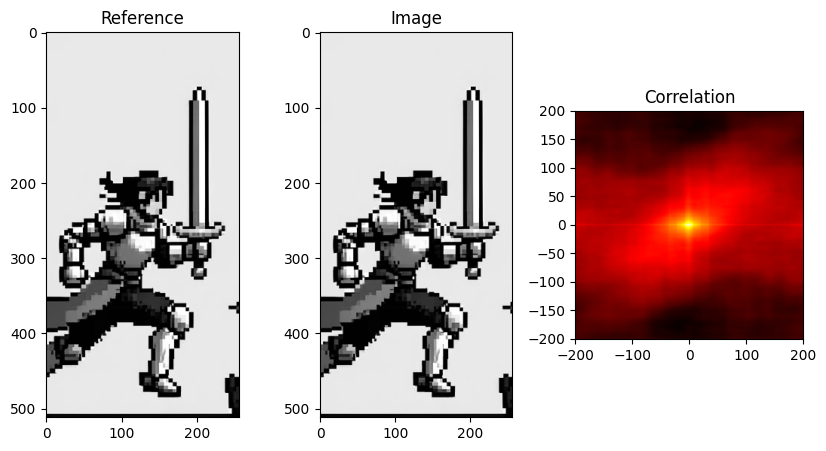

0 0


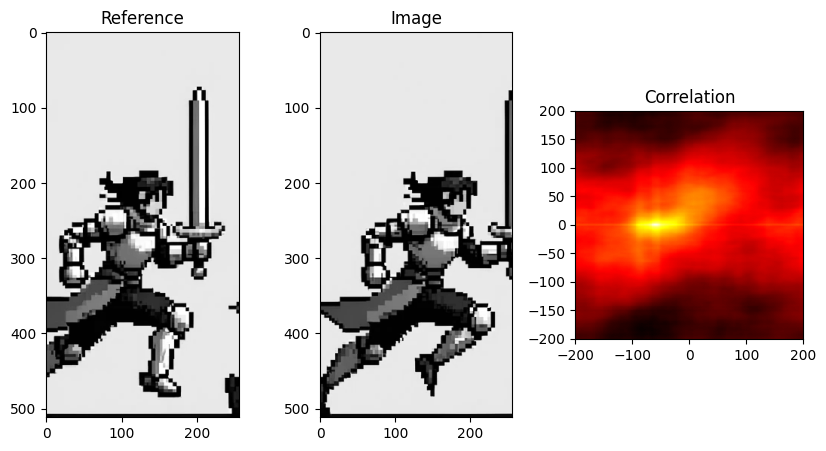

0 -37


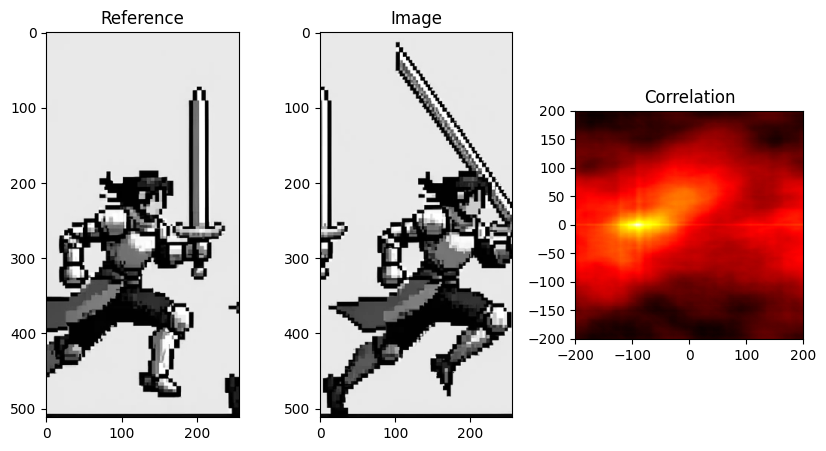

0 -58


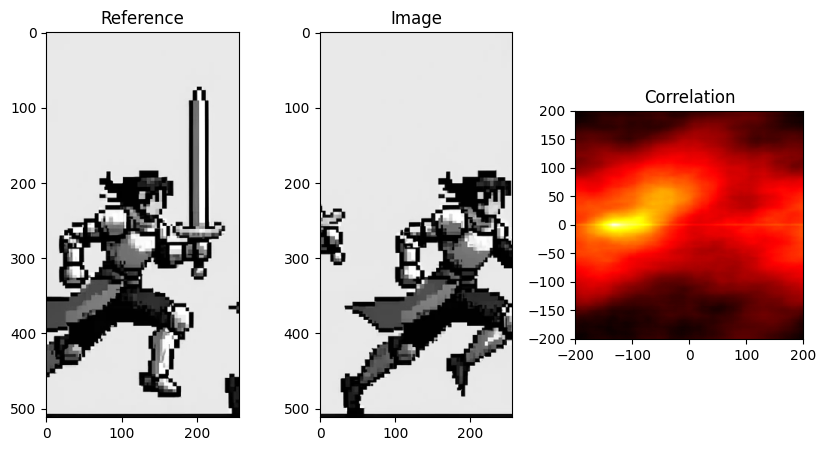

0 -83


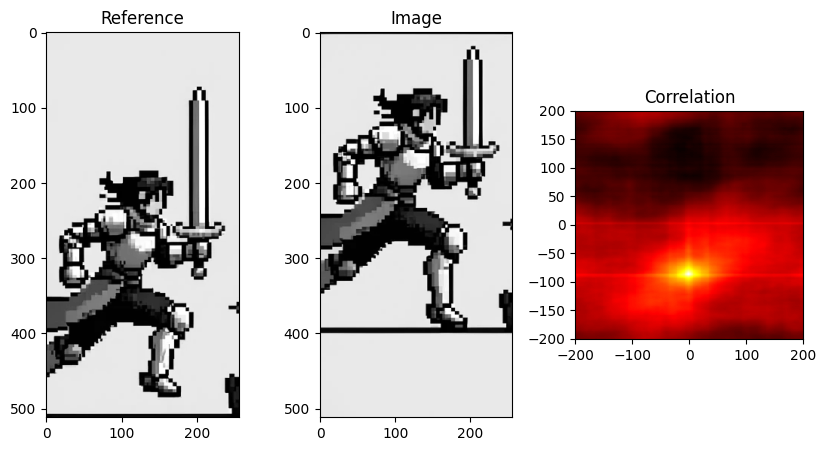

100 0


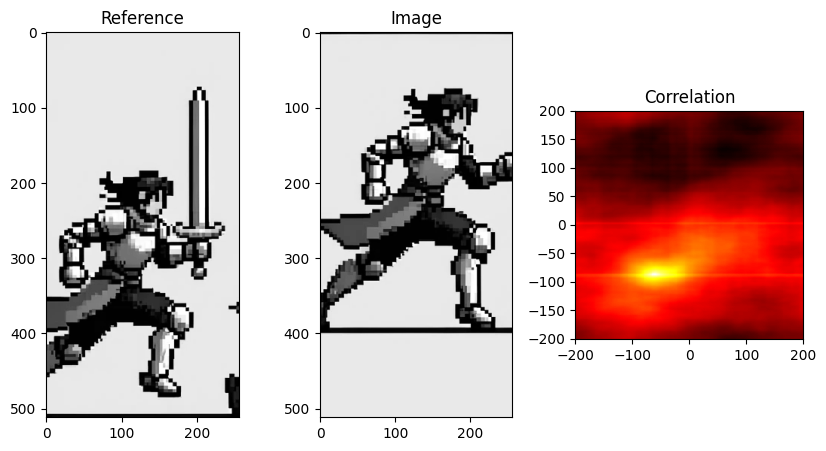

100 -37


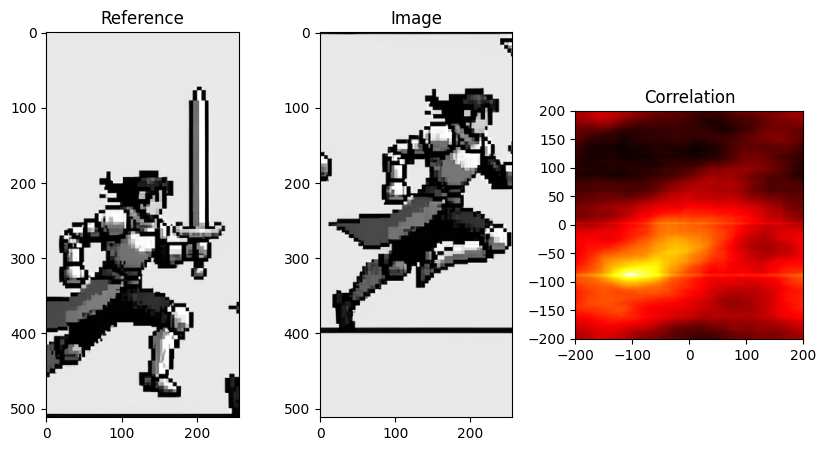

100 -58


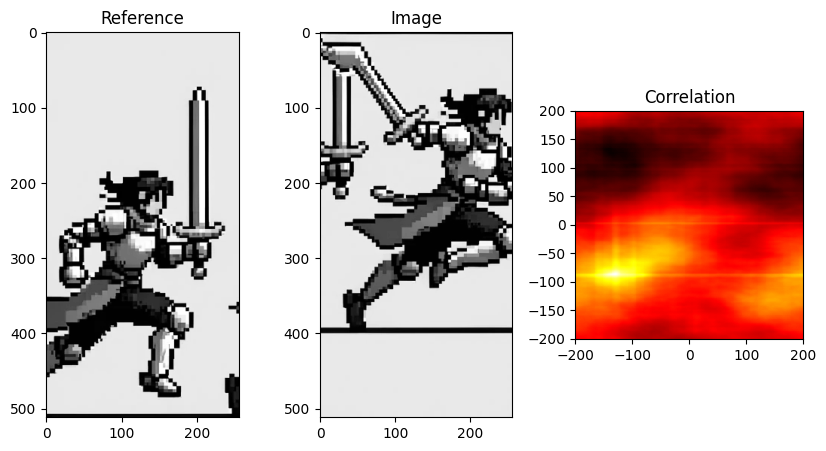

100 -81


'output.gif'

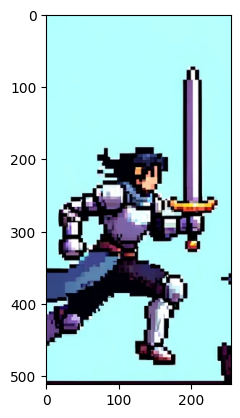

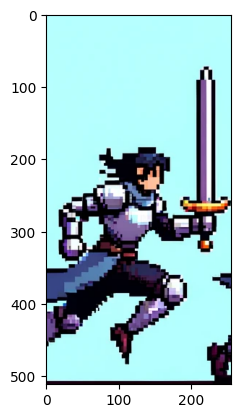

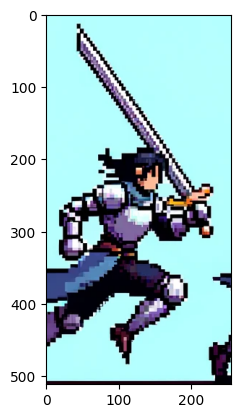

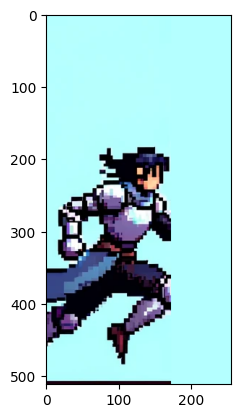

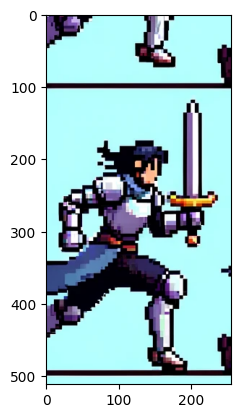

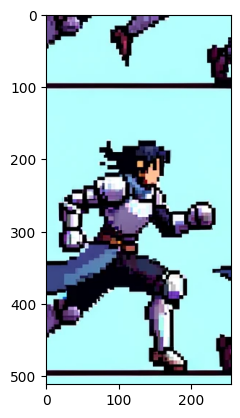

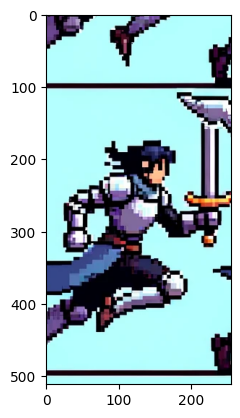

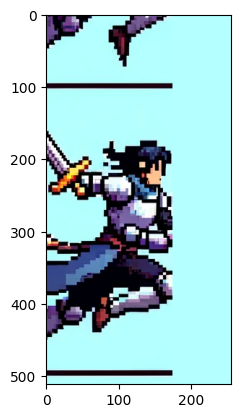

In [54]:
create_aligned_gif(img,[4,4])

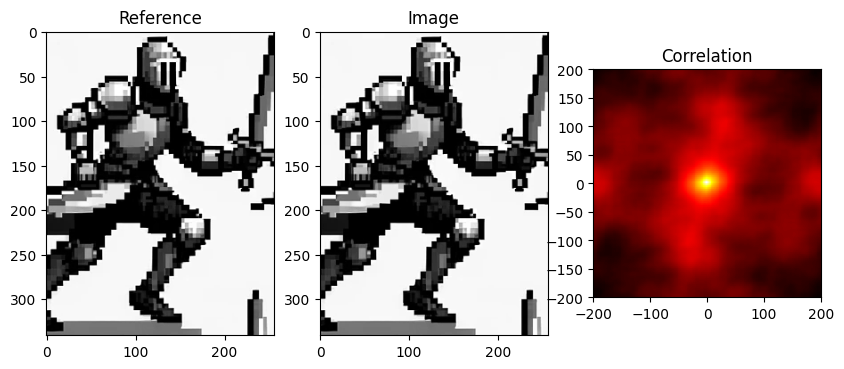

0 0


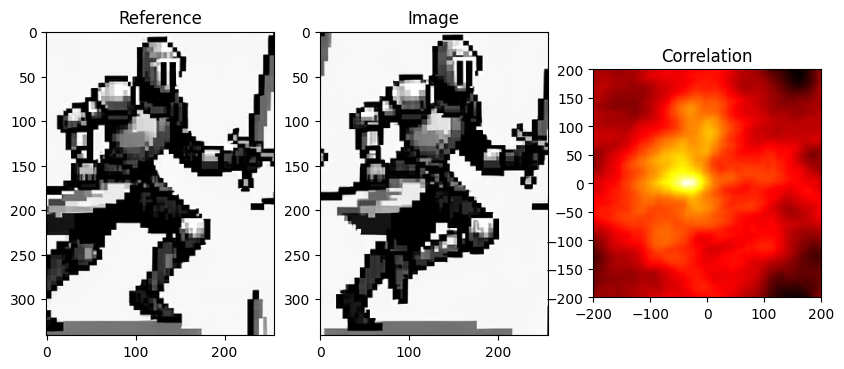

1 -23


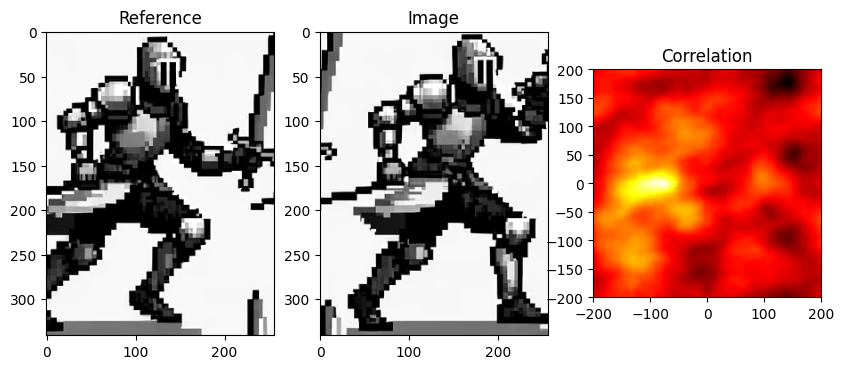

2 -48


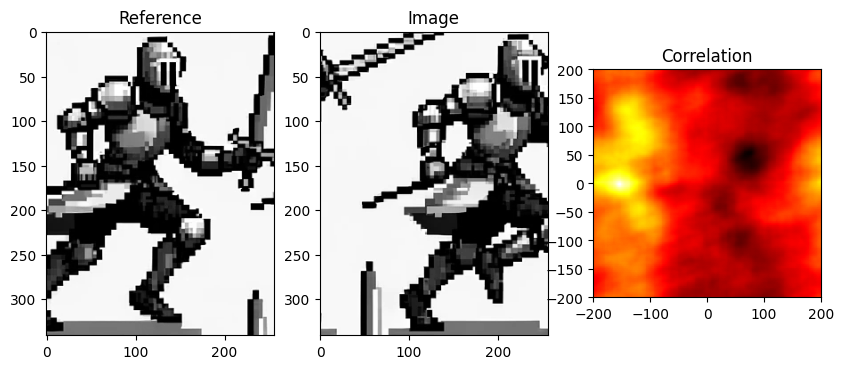

3 -98


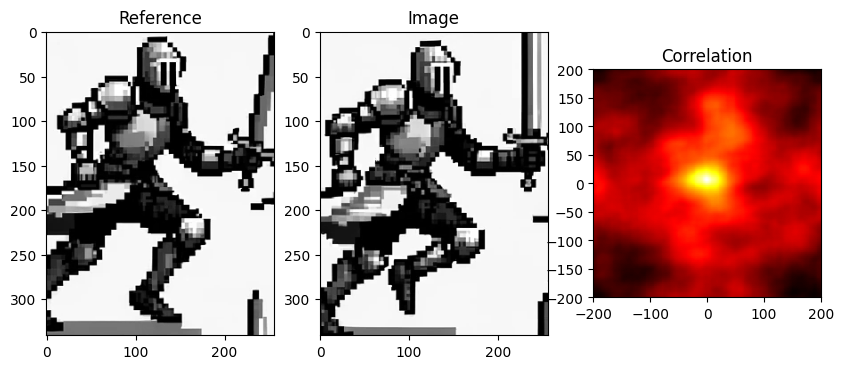

-4 0


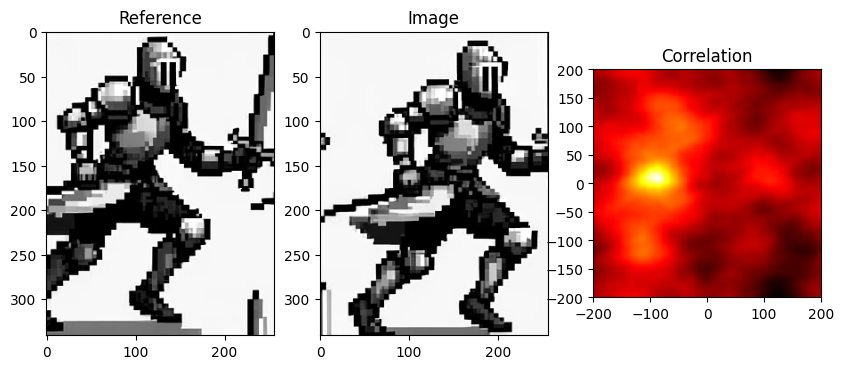

-6 -54


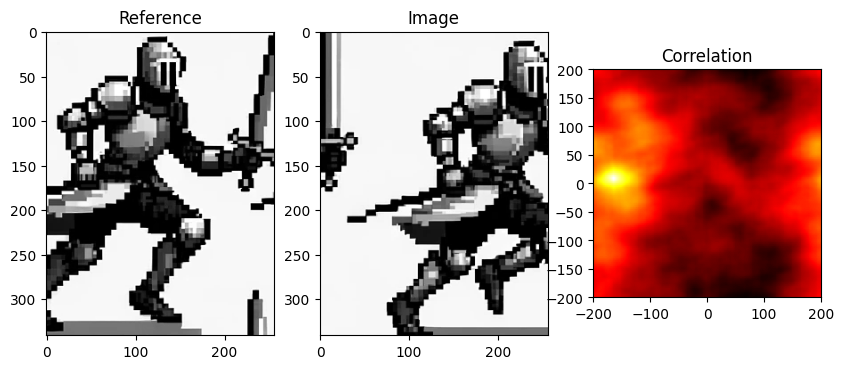

-6 -99


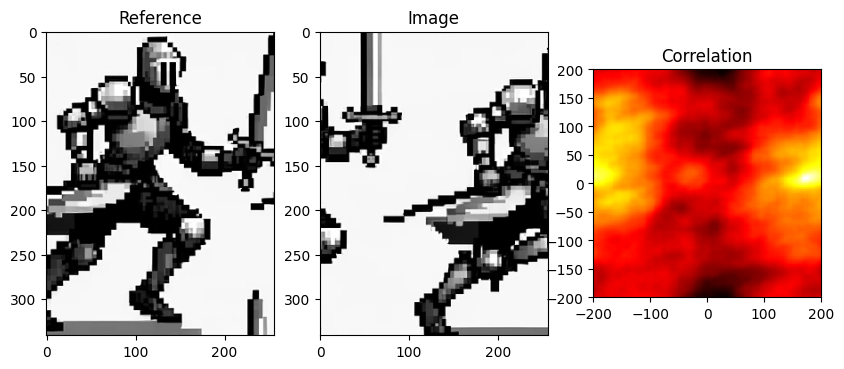

-2 100


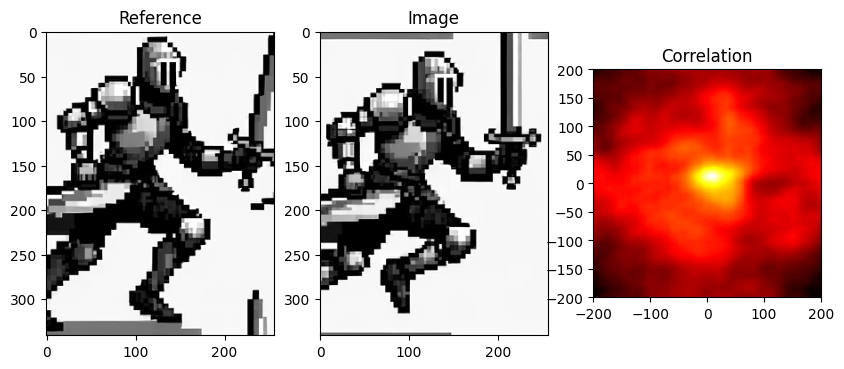

-9 7


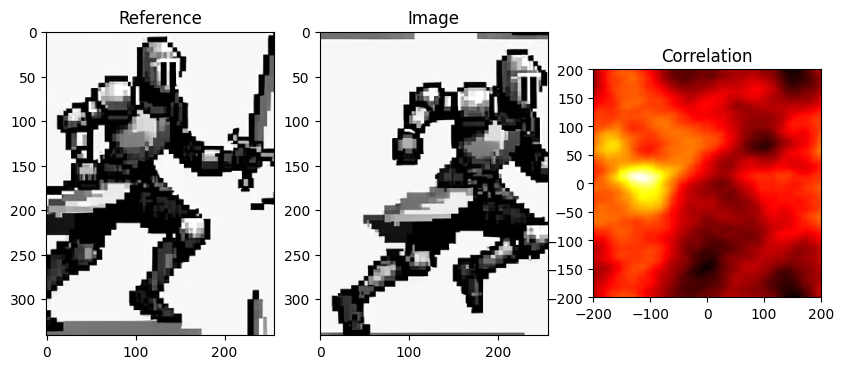

-9 -77


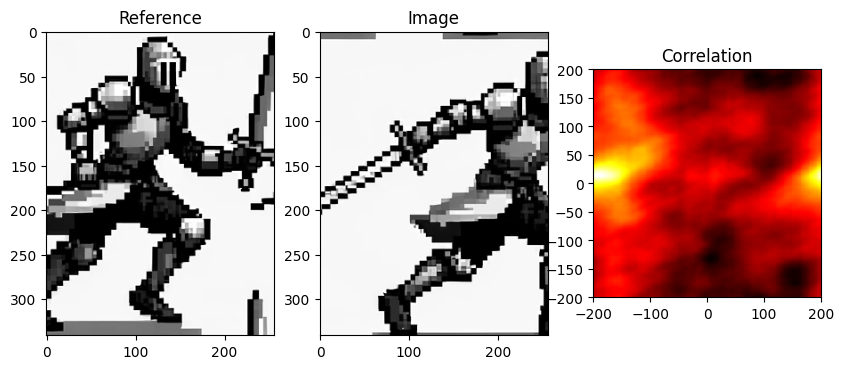

-12 -99


'd:/img/foo/ss3.gif'

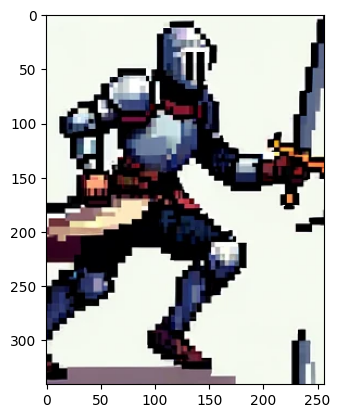

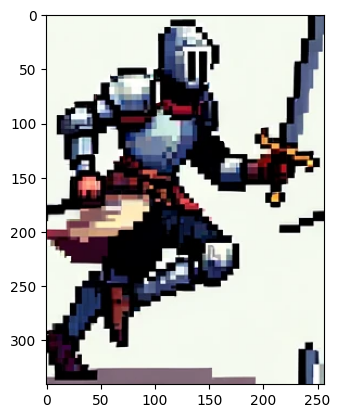

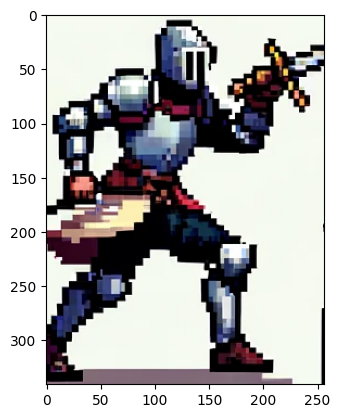

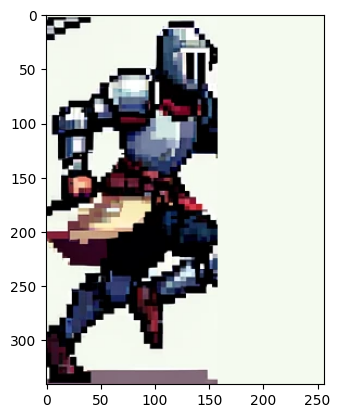

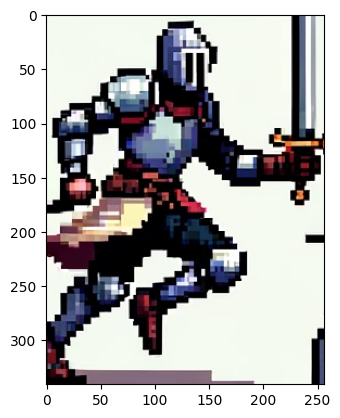

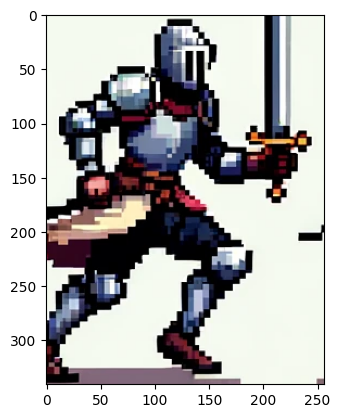

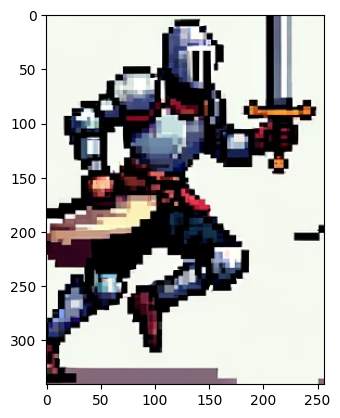

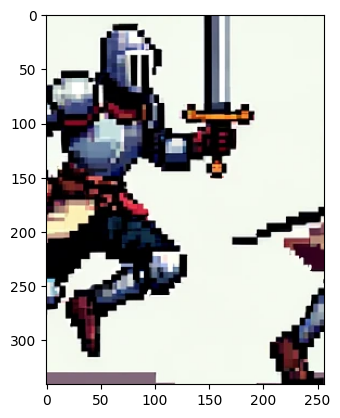

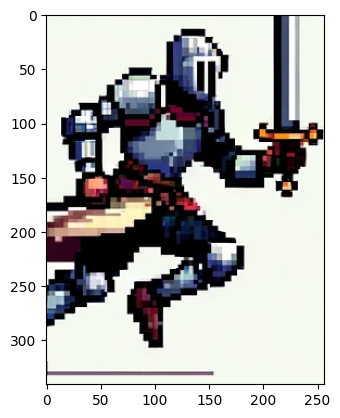

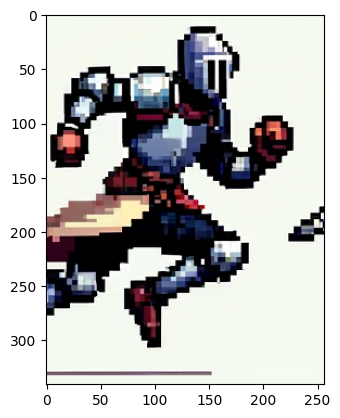

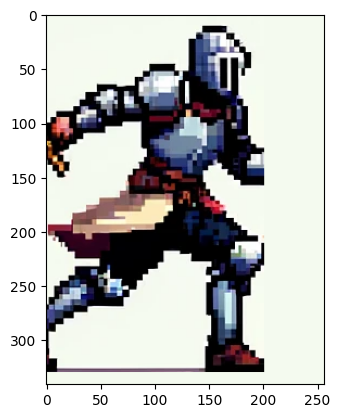

In [55]:
img=Image.open("D:/img/foo/ss3.png")
img
create_aligned_gif(img,[4,4,3],output_gif_path="d:/img/foo/ss3.gif")